In [156]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import sys

import numpy as np

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from src import get_data_loaders

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
device = torch.device(device)
print(f"Using {device} device")

Using mps device


# Load Data

In [157]:
data_dir=os.path.join(os.getcwd(), '../Data', 'Parsed_Data_Window')
train_val_data_to_load=math.inf
test_data_to_load=math.inf
faste_files_to_load = 37
normalize = False
batch_size = 128
train_loader, val_loader, test_loader = get_data_loaders(
    data_dir=data_dir,
    train_val_data_to_load=train_val_data_to_load,
    test_data_to_load=test_data_to_load,
    batch_size=batch_size,
    faste_files_to_load=faste_files_to_load,
    normalize=normalize)

Loading sequences from sequences.fasta
Loading coverage from SRX391990.faste
Loading coverage from SRX9770779.faste
Loading coverage from SRX9770784.faste
Loading coverage from SRX9770786.faste
Loading coverage from SRX391992.faste
Loading coverage from SRX391996.faste
Loading coverage from SRX9770782.faste
Loading coverage from SRX1098138.faste
Loading coverage from SRX9770780.faste
Loading coverage from SRX391994.faste
Loading coverage from SRX9770787.faste
Loading coverage from SRX391993.faste
Loading coverage from SRX9770778.faste
Loading coverage from SRX391991.faste
Loading coverage from SRX9770785.faste
Loading coverage from SRX9770781.faste
Loading coverage from SRX391995.faste
Loading coverage from SRX391997.faste
Loading coverage from SRX9770783.faste
Loading coverage from SRX1098137.faste
Loading coverage from SRX1098135.faste
Loading coverage from SRX1096550.faste
Loading coverage from SRX9770774.faste
Loading coverage from SRX9770789.faste
Loading coverage from SRX9770790.

# Build Model

In [ ]:
class LocalDnaCnn(nn.Module):
    def __init__(self, num_kernels=[256, 128, 64, 32], kernel_size=[16,16,16,16],
                 dropout=0, transformer_heads=4, transformer_layers=3):
        super(LocalDnaCnn, self).__init__()
        self.input_channels=4
        self.num_kernels=num_kernels
        self.kernel_size=kernel_size
        self.dropout=dropout
        self.transformer_heads=transformer_heads
        self.transformer_layers=transformer_layers
        self.conv_block = nn.Sequential(
            # first layer
            nn.Conv1d(in_channels=self.input_channels,
                      out_channels=num_kernels[0],
                      kernel_size=kernel_size[0]),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.MaxPool1d(kernel_size=2),
        )
        # second layer
        self.conv_block.append(nn.Sequential(
            nn.Conv1d(in_channels=self.num_kernels[0],
                      out_channels=num_kernels[1],
                      kernel_size=kernel_size[1]),
            #nn.BatchNorm1d(num_features=num_kernels[1]),
            nn.ReLU(),
            nn.Dropout(p=self.dropout),   
            nn.MaxPool1d(kernel_size=2),        
        ))
        # Add a third convolutional layer
        self.conv_block.append(nn.Sequential(
            # second layer
            nn.Conv1d(in_channels=self.num_kernels[1],
                      out_channels=num_kernels[2],
                      kernel_size=kernel_size[2]),
            #nn.BatchNorm1d(num_features=num_kernels[2]),
            nn.ReLU(),
            nn.Dropout(p=self.dropout),   
            nn.MaxPool1d(kernel_size=2),  
        ))
        # Add a fourth convolutional layer
        self.conv_block.append(nn.Sequential(
            # second layer
            nn.Conv1d(in_channels=self.num_kernels[2],
                      out_channels=num_kernels[3],
                      kernel_size=kernel_size[3]),
        #    #nn.BatchNorm1d(num_features=num_kernels[2]),
            nn.ReLU(),
            nn.Dropout(p=self.dropout),
            nn.MaxPool1d(kernel_size=2),  
        ))
        # Add a dilated convolutional layer
        #self.conv_block.append(nn.Sequential(
        #    # second layer
        #    nn.Conv1d(in_channels=self.num_kernels[3],
        #              out_channels=num_kernels[3],
        #              kernel_size=kernel_size[3],
        #              dilation=2),
            #nn.BatchNorm1d(num_features=num_kernels[2]),
        #    nn.ReLU(),
        #    nn.Dropout(p=self.dropout), 
        #))
        # Add a dilated convolutional layer
        #self.conv_block.append(nn.Sequential(
        #    # second layer
        #    nn.Conv1d(in_channels=self.num_kernels[3],
        #              out_channels=num_kernels[3],
        #              kernel_size=kernel_size[3],
        #              dilation=4),
        #    #nn.BatchNorm1d(num_features=num_kernels[2]),
        #    nn.ReLU(),
        #    nn.Dropout(p=self.dropout),  
        #))
        # Add a dilated convolutional layer
        #self.conv_block.append(nn.Sequential(
        #    # second layer
        #    nn.Conv1d(in_channels=self.num_kernels[3],
        #              out_channels=num_kernels[3],
        #              kernel_size=kernel_size[3],
        #              dilation=8),
        #    #nn.BatchNorm1d(num_features=num_kernels[2]),
        #    nn.ReLU(),
        #    nn.Dropout(p=self.dropout),  
        #))
        
        # Add a fourth convolutional layer
        #self.conv_block.append(nn.Sequential(
        #    nn.Conv1d(in_channels=self.num_kernels[2],
        #              out_channels=num_kernels[3],
        #              kernel_size=kernel_size[3]),
        #    nn.ReLU(),
        #    nn.Dropout(p=self.dropout),         
        #))

        # the transformer is a combo of multiple encoder layers
        #self.transformer = nn.TransformerEncoder(
        #    nn.TransformerEncoderLayer(2144,
        #                               nhead=self.transformer_heads),
        #                               self.transformer_layers)
        self.attention_weights = None  # Store attention weights
        self.regression_block = nn.Sequential(
            nn.Linear(64, 128),
            nn.Dropout(p=self.dropout),
            nn.ReLU(),
            nn.Linear(128, faste_files_to_load),
        ) 

    def forward(self, x):
        x = self.conv_block(x)
        x =  torch.flatten(x, 1)
        #x,_ = torch.max(x, dim=2) 
        #x = self.transformer(x)     
        x = self.regression_block(x)
        return x

# Train Model

### Training functions

In [159]:
def train_epoch(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader)
    num_batches = len(dataloader)
    total_loss = 0
    # set the model to training mode - important when you have 
    # batch normalization and dropout layers
    model.train()
    for batch_idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        # Compute prediction and loss
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        # backpropagation
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0 :
        print(f"training loss: {total_loss/num_batches:>7f}")
    return total_loss / num_batches

def validation(dataloader, model, loss_fn, epoch):
    # set the model to evaluation mode 
    model.eval()
    # size of dataset
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validation_loss = 0
    # Evaluating the model with torch.no_grad() ensures that no gradients 
    # are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage 
    # for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            validation_loss += loss_fn(y_pred, y).item()
    validation_loss /= num_batches
    if epoch%10 == 0 :
        print(f"Validation Loss: {validation_loss:>8f} \n")
    return validation_loss

def train_model(train_loader, val_loader, model, optimizer, loss_fn, lr_scheduler, epochs, overfit_ratio=0.85):

    train_loss = []
    validation_loss = []
    for t in range(epochs):
        if t % 1 == 0 :
            print(f"Epoch {t}\n-------------------------------")
        loss = train_epoch(train_loader, model, loss_fn, optimizer, t)
        train_loss.append(loss)
        loss = validation(val_loader, model, loss_fn, t)
        validation_loss.append(loss)
    
        if train_loss[-1] < validation_loss[-1]:
            # print(f"Training loss {train_loss[-1]} is less than validation loss {validation_loss[-1]}")

            if train_loss[-1]/validation_loss[-1] < overfit_ratio:
                print(f"Training loss {train_loss[-1]} is well below validation loss {validation_loss[-1]}")
                break
        lr_scheduler.step()
                
    print("Done!")

    def plot_loss(train_loss, validation_loss):
        plt.figure(figsize=(4,3))
        plt.plot(np.arange(len(train_loss)), train_loss, label='Training')
        plt.plot(np.arange(len(validation_loss)), validation_loss, label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        # plt.savefig('')
        plt.show()
    plot_loss(train_loss, validation_loss)


### Train

In [ ]:
num_kernels=[320, 128, 64, 32]
kernel_size=[10,10,10,10]
dropout=0.3
transformer_heads=4
transformer_layers=3
lr = 0.01
faste_files_to_load=37
decay_rate = 0.97

model = LocalDnaCnn(num_kernels=num_kernels,
                    kernel_size=kernel_size,
                    dropout=dropout,
                    transformer_heads=transformer_heads,
                    transformer_layers=transformer_layers).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.PoissonNLLLoss(log_input=True, full=True)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)
train_model(train_loader=train_loader,
            val_loader=val_loader,
            model=model,
            optimizer=optimizer,
            loss_fn=loss_fn,
            lr_scheduler=lr_scheduler,
            epochs=40,
            overfit_ratio=0.85)

Epoch 0
-------------------------------
training loss: 0.916816
Validation Loss: 0.914230 

Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------
Epoch 8
-------------------------------
Epoch 9
-------------------------------
Epoch 10
-------------------------------
training loss: 0.839995
Validation Loss: 0.856857 

Epoch 11
-------------------------------
Epoch 12
-------------------------------
Epoch 13
-------------------------------
Epoch 14
-------------------------------
Epoch 15
-------------------------------
Epoch 16
-------------------------------
Epoch 17
-------------------------------
Epoch 18
-------------------------------
Epoch 19
-------------------------------
Epoch 20
-------------------------------
training loss: 0.823263
Validation Loss: 0.84

KeyboardInterrupt: 

### Save Model

In [ ]:
torch.save(model, "../Ted_Models/051_3layer_CNN_kernel_size_10.pth")

### Validate Model

In [183]:
model = torch.load(os.path.join(os.getcwd(), "../Ted_Models/0511_3layer_CNN_256.pth"))
model.to(device)
model.eval()

/var/folders/yz/r_df664j0kl4q1cg3b7888qw0000gn/T/ipykernel_69648/1019637125.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.join(os.getcwd(), 

LocalDnaCnn(
  (conv_block): Sequential(
    (0): Conv1d(4, 320, kernel_size=(10,), stride=(1,))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Conv1d(320, 128, kernel_size=(10,), stride=(1,))
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (5): Sequential(
      (0): Conv1d(128, 64, kernel_size=(10,), stride=(1,))
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=2144, out_features=2144, bias=True)
        )
        (linear1): Linear(in_features=2

In [184]:
X, y = next(iter(test_loader))
X = X.to(device)

y = y.to(device)
y_pred = model.forward(X).to(device)
y_pred = torch.exp(y_pred)

print(y[0])
print(y_pred[0])

loss_fn = nn.PoissonNLLLoss(log_input=True, full=True)
print(loss_fn(y_pred, y))

tensor([0.2136, 0.0000, 0.2432, 0.1927, 0.1863, 0.1760, 0.3666, 0.2505, 0.0000,
        0.1623, 0.1860, 0.1319, 0.0000, 0.0000, 0.1959, 0.3558, 0.1809, 0.2076,
        0.1829, 0.2244, 0.0723, 0.1670, 0.0357, 0.3765, 0.2121, 0.1970, 0.2892,
        0.3346, 0.4501, 0.1220, 0.0679, 0.0664, 0.2427, 0.0000, 0.3025, 0.1894,
        0.2202], device='mps:0')
tensor([0.8038, 0.5359, 0.5706, 0.4410, 0.7183, 0.4955, 0.5632, 0.7160, 0.4867,
        0.6405, 0.4476, 0.5244, 0.4082, 0.6071, 0.4506, 0.5633, 0.4469, 0.5131,
        0.5623, 0.5504, 0.5153, 0.5946, 0.5483, 0.6392, 0.6390, 0.5853, 0.6344,
        0.4994, 0.5063, 0.5170, 0.7097, 0.5470, 0.4946, 0.4663, 0.7937, 0.5725,
        0.6338], device='mps:0', grad_fn=<SelectBackward0>)
tensor(1.5572, device='mps:0', grad_fn=<MeanBackward0>)


In [ ]:
i = 2
print('Tissue: Predicted, True')
for s, (y_p, y_t) in enumerate(zip(y_pred[i], y[i])):
    print(f'{s}: {y_p:.3f}, {y_t:.3f}')

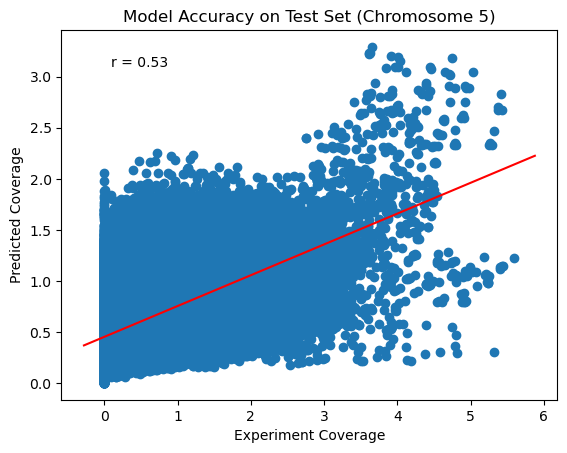

In [191]:
with torch.no_grad():
        model.eval()
        pred_list = []
        labels_list = []
        for batch_index, (X, y) in enumerate(test_loader):
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)
            y_pred = torch.exp(y_pred)
            y_pred = torch.flatten(y_pred).cpu().detach().numpy()
            pred_list.append(y_pred)

            y = torch.flatten(y).cpu().numpy()
            labels_list.append(y)

            #y_pred = y_pred.cpu().detach().numpy().reshape(output.shape[0])
            #labels=target.cpu().numpy().reshape(output.shape[0])
            
        labels = np.concatenate(labels_list)
        predictions = np.concatenate(pred_list)
        
pearson_r = np.corrcoef(labels, predictions)[0, 1]

plt.scatter(labels, predictions)
plt.xlabel("Experiment Coverage")
plt.ylabel("Predicted Coverage")
plt.title("Model Accuracy on Test Set (Chromosome 5)")
plt.text(0.1, 0.9, f"r = {pearson_r:.2f}", transform=plt.gca().transAxes)
#m, b = np.polyfit(y, y_pred, 1)
coeffs = np.polyfit(labels, predictions, 1)
polynomial = np.poly1d(coeffs)
X_plot = np.linspace(plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], 100)
y_plot = polynomial(X_plot)
plt.plot(X_plot, y_plot, color='red')
plt.savefig('LocalDnaCnnAccuracy.png')
plt.show()

In [ ]:
def loss_true(input, target):
    return math.exp(input) - target*input

def loss_false(input, target):
    return input - target*math.log(input)


y = 0.5
y_mod = math.log(y+1)
print(y_mod)


y_pred = 0.5

print(loss_false(y_pred, y))

In [ ]:
len(model.conv_weights), model.conv_weights[1].shape

0
9.110652
1
9.1578865
2
9.36291
3
8.423701
4
9.091902
5
8.59742
6
8.94759
7
8.343486
8
7.4659085
9
8.753144
10
9.464031
11
8.46637
12
9.411591
13
7.7346296
14
8.117671
15
7.834945
16
8.392238
17
8.737217
18
8.5294
19
8.120421
20
7.9489884
21
8.247141
22
8.329848
23
8.74843
24
9.333687
25
9.032671
26
8.894755
27
7.9245453
28
8.495373
29
9.108327
30
7.854624
31
9.243919
32
8.489335
33
8.951893
34
8.062566
35
8.957606
36
8.581879
37
8.816185
38
8.658458
39
8.343023
40
8.040228
41
9.5796
42
8.372913
43
8.477244
44
8.178753
45
8.857256
46
8.51882
47
8.817595
48
9.325299
49
8.946124
50
8.851382
51
9.145517
52
7.4921746
53
9.134778
54
8.2643585
55
8.96061
56
9.066018
57
9.191827
58
8.9925375
59
9.203187
60
8.507488
61
8.600995
62
9.557584
63
8.060581
64
7.968252
65
8.38283
66
9.017091
67
7.8643017
68
8.625801
69
8.094061
70
8.807729
71
9.02677
72
9.2215185
73
8.821319
74
8.888786
75
9.463633
76
8.923285
77
8.636036
78
9.150033
79
8.542625
80
7.759818
81
9.41575
82
7.9659023
83
8.493005
84
9.

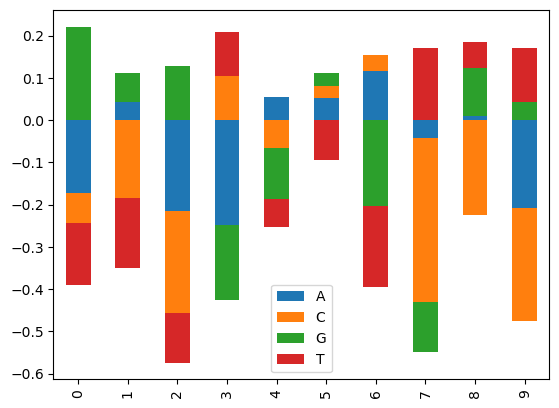

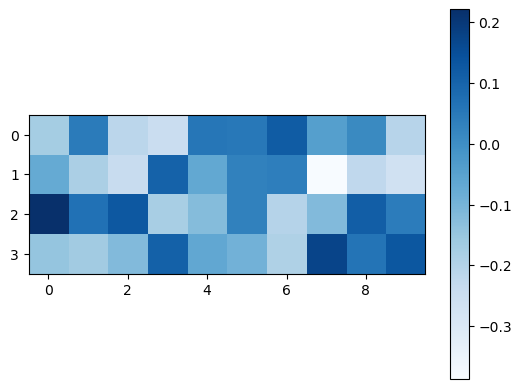

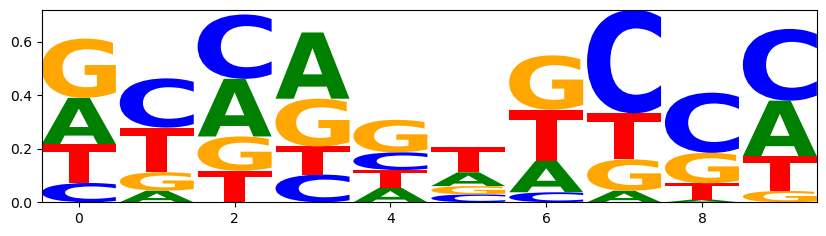

In [173]:
import logomaker
weights=model.conv_block[0].weight.detach().cpu().numpy()
weights.shape

#motif = pd.DataFrame(weights[filter].T, columns=['A','C','G','T']).abs()

def calc_entropy(row):
    H = 0
    for n in ['A', 'C', 'G', 'T']:
        H -= row[n] * math.log(row[n])
    return H

def create_profile_logo(motif_probs):
    """
    Creates a profile logo based on the motif probabilities

    parameters:
    motif_probs: a 2D array, with dims [k, 4], populated with
    the probabilities of each nucleotide at each position

    Displays the profile logo
    """
    mat = pd.DataFrame(motif_probs)
    mat.columns = ['A', 'C', 'G', 'T']
    logomaker.Logo(mat)


max_h = 0
max_i = 0
for i in range(len(weights)) :
    print(i)
    motif = pd.DataFrame(weights[i].T, columns=['A','C','G','T']).abs()
    motif['entropy'] = motif.apply(calc_entropy, axis=1)
    total_entropy = motif['entropy'].sum()
    if total_entropy > max_h:
        max_h = total_entropy
        max_i = i
    print(total_entropy)
print(max_i)

motif = pd.DataFrame(weights[max_i].T, columns=['A','C','G','T'])
motif.plot.bar(stacked=True, use_index=True)

fig = plt.figure()
plt.imshow(weights[max_i],cmap="Blues")
plt.colorbar()

create_profile_logo(motif.abs())